# Implementarea DeepDream în Keras

În primul rând, încărcăm modelul InceptionV3, care tinde să producă unele dintre cele mai bune elemente vizuale. Simțiți-vă liber să încercați VGG16, VGG19, Xception și ResNet50.

Cod obținut și editat din F. Chollet (Creat din Keras)

https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.2-deep-dream.ipynb

In [1]:
from keras.applications import inception_v3
from keras import backend as K

#Aceasta setare dezactiveaza toate operatiunile specifice de instruire
K.set_learning_phase(0)

#Incarca InceptionV3
model = inception_v3.InceptionV3(weights = 'imagenet', include_top = False)

Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.


Cream un dictionar de coeficienti care cuantifica cat de mult contribuie activarea statului la pierderea(loss) pe care o cautam sa  o maximizam

In [2]:
layer_contributions = {
    'mixed2': 0.7,
    'mixed3': 2.2,
    'mixed4': 1.2,
    'mixed5': .2,
}

Definiti tensorul care continemaximizarea pierderi (suma pnderata a normei L2 a activarilor stratului definit mai sus)

In [5]:
#map layer names to layer instances
layer_dict = dict([(layer.name, layer) for layer in model.layers])

#definire loss prin adugarea constibutilor la strat
loss = K.variable(0.)

for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]

    #activare primește rezultatul stratului
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))

    #adaugam normala l2
    
    loss = loss +  coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

# Creaza process Gradient-ascent

In [8]:
# Aceasta ține imaginea noastră generată
dream = model.input

#Calculati gradients al dream cu ceea ce priveste loss
grads = K.gradients(loss, dream)[0]

#Normaliza gradient
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

#Setati functia pentru a prelua valoarea piederii si a dradientilor dati de o imagine
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    """returneaza loss si valoarea gradient """
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    "Implementează accesul gradient pentru un număr specific de iterații"
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value> max_loss:
            break
        print("...Loss value at", i , ':', loss_value)
        x += step * grad_values
    return x

# Implementare Algoritmului Deep Dream

In [17]:
import scipy
import imageio
import numpy as np
from keras.preprocessing import image

def resize_image(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0])/ img.shape[1],
               float(size[1])/ img.shape[2],
               1
               )
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    #scipy.misc.imsave(fname, pil_img)
    imageio.imsave(fname, pil_img)
    

def preprocess_image(iamge_path):
    #utilizem functia pentru a deschide, redimensiona si formata imaginea
    #intr-un tensor adecvat.
    img = image.load_img(iamge_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    #utilizam functia pentru a converti tensor intro imagine valida
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.traspose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [18]:
# Jucanduva cu aceste hiperparametre va permita de asemenea sa obtineti un efect nou

step = 0.01    #gradien ascent pas dimensiune
num_octave = 3 #Numarul de scare la care se poate efectua dradient ascent
octave_scale = 1.4 #dimensiune ratio intre scare/scale
iterations =20 #Numarul de trepte se ascent pe scara

#daca loss este mai mare decat 10
#vom intrerupe procesul lui gradient ascent, pentru a evita ca imaginile sa devina urate
max_loss = 10

#Aceasta setea calea catre imaginea pe care vrem sa o folosim
base_image_path = 'c:/Users/Harum/Documents/23/images/deep.jpg'

#incarca imaginea intr-un Numpy array
img = preprocess_image(base_image_path)

#vom prepara o lista a formei/shape tuples
#definim diferite scale(scare) la care vom efectua gradient ascent
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale **i)) for dim in original_shape])
    successive_shapes.append(shape)

#Reverseaza lista a dimensiunilor, astfel incat sa fie in ordine crescatoare
successive_shapes = successive_shapes[::-1]

#Redimensionare Numpy array a imagini  la o scala/scara cea  mai mica
original_shape = np.copy(img)
shrunk_original_img = resize_image(img,successive_shapes[0])

for shape in successive_shapes:
    print("Processing imag shape", shape)
    img = resize_image(img, shape)
    img = gradient_ascent(img,
                         iterations=iterations,
                         step=step,
                         max_loss=max_loss)
    upscaled_shrunk_original_img =resize_image(shrunk_original_img, shape)
    same_size_original = resize_image(original_shape, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img = img + lost_detail
    shrunk_original_img = resize_image(original_shape, shape)
    save_img(img, fname="dream_at_scale_" + str(shape)+ ".png")

save_img(img, fname="final_dream.png")

Processing imag shape (178, 178)
...Loss value at 0 : 0.5553875
...Loss value at 1 : 0.82172775
...Loss value at 2 : 1.2039969
...Loss value at 3 : 1.5906702
...Loss value at 4 : 1.9441416
...Loss value at 5 : 2.336141
...Loss value at 6 : 2.7498457
...Loss value at 7 : 3.090295
...Loss value at 8 : 3.4195724
...Loss value at 9 : 3.746098
...Loss value at 10 : 4.061282
...Loss value at 11 : 4.4147387
...Loss value at 12 : 4.653088
...Loss value at 13 : 5.023495
...Loss value at 14 : 5.366948
...Loss value at 15 : 5.7541485
...Loss value at 16 : 6.052352
...Loss value at 17 : 6.333554
...Loss value at 18 : 6.697091
...Loss value at 19 : 7.0538445
Processing imag shape (250, 250)
...Loss value at 0 : 1.8807151
...Loss value at 1 : 3.0884702
...Loss value at 2 : 4.1439304
...Loss value at 3 : 5.2539124
...Loss value at 4 : 6.6751704
...Loss value at 5 : 8.518865
Processing imag shape (350, 350)
...Loss value at 0 : 2.9731984
...Loss value at 1 : 5.453193
...Loss value at 2 : 8.341051


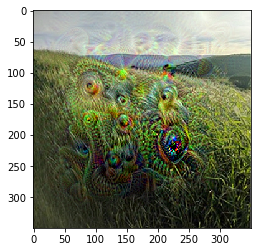

In [19]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()